In [1]:
import os
import cv2
from PIL import Image

dataset_path = "D:\\ai\\Dataset"
output_dataset_path = "Train_images"
image_extensions = (".jpg", ".jpeg", ".png")
IMG_SIZE = (224, 224)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [3]:
subfolders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

for subfolder in subfolders:
    subfolder_path = os.path.join(dataset_path,subfolder)
    output_subfolder = os.path.join(output_dataset_path , subfolder)
    os.makedirs(output_subfolder , exist_ok = True)

    for filename in os.listdir(subfolder_path):
        if filename.lower().endswith(image_extensions):
            image_path = os.path.join(subfolder_path , filename)
            output_image_path = os.path.join(output_subfolder,filename)

            img = cv2.imread(image_path)
            if img is None:
                print(f'could not read image')
            gray = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)

            faces = face_cascade.detectMultiScale(gray , scaleFactor = 1.1 , minNeighbors = 5 , minSize = (30,30))
            
            if len(faces) > 0 :
               
               faces = sorted(faces , key = lambda f:f[2]*f[3] , reverse = True)
               x , y , w , h = faces[0]

               padding = 10
               y_start = max(0 , y - padding)
               y_end = min(img.shape[0] , y + h + padding)
               x_start = max(0 , x - padding)
               x_end = min(img.shape[1] , x + w + padding)

               cropped_face = img[y_start:y_end , x_start:x_end]

               cropped_face = cv2.resize(cropped_face , IMG_SIZE)

               cv2.imwrite(output_image_path , cropped_face)
            else:
                img = cv2.resize(img , IMG_SIZE)
                cv2.imwrite(output_image_path , img)
        else:
            print(f'skipping non-image file:{filename}')
print('Processing Complete . Cropped Images are in "Train Images" directory')

skipping non-image file:100.jpg_
skipping non-image file:56.jpg_
skipping non-image file:86.jpg_
Processing Complete . Cropped Images are in "Train Images" directory


In [2]:
import torch
import numpy as np
import random

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

import torch.nn as nn 
from torchvision import datasets , transforms , models
from torch.utils.data import DataLoader , random_split

IMG_SIZE = (224,224)
Batch_size = 32
VAL_SPLIT = 0.2

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(IMG_SIZE , scale  =(0.9 , 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485 , 0.456 , 0.406] , std = [0.229 , 0.224 , 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize((224 , 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485 , 0.456 , 0.406] , std = [0.229 , 0.224 , 0.225 ])
])

dataset = datasets.ImageFolder('Train_images' , transform = transform_train)

print(f'Total Images found:{len(dataset)}')
print(f'classes : {dataset.classes}')

val_size = int(len(dataset) * VAL_SPLIT)
train_size = int(len(dataset) - val_size)

train_set , val_set = random_split(dataset , [train_size , val_size])

val_set.dataset.transform = transforms_val

train_loader = DataLoader(train_set , batch_size = Batch_size , shuffle = True)
val_loader = DataLoader(val_set , batch_size = Batch_size , shuffle  = False )


Total Images found:397
classes : ['clear face', 'darkspots', 'puffy eyes', 'wrinkles']


In [212]:
labels = []
for _,label in dataset:
    labels.append(label)

In [220]:
labels = np.array(labels)
class_0 = len(labels[labels == 0])
class_1 = len(labels[labels == 1])
class_2 = len(labels[labels == 2])
class_3 = len(labels[labels == 3])

## Distribution

<BarContainer object of 4 artists>

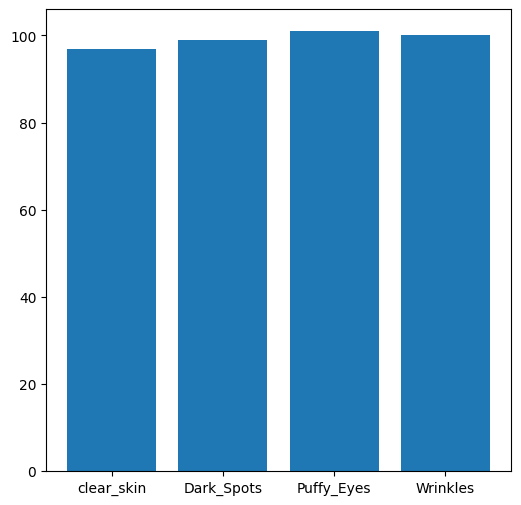

In [223]:
import matplotlib.pyplot as plt
plt.figure(figsize = (6,6))
x_values = [class_0 , class_1 , class_2 , class_3]
y_values = ['clear_skin','Dark_Spots','Puffy_Eyes','Wrinkles']
plt.bar(y_values,x_values)

In [229]:
x_values

[97, 99, 101, 100]

([<matplotlib.patches.Wedge at 0x22686884ed0>,
 [Text(0.7915424799267752, 0.7638458630321766, 'clear_skin'),
  Text(-0.7480380631646505, 0.8064980198716414, 'Dark_Spots'),
  Text(-0.7975622005027126, -0.7575582725634187, 'Puffy_Eyes'),
  Text(0.7731874407146069, -0.7824200799578168, 'Wrinkles')],
 [Text(0.4317504435964228, 0.41664319801755084, '24.4%'),
  Text(-0.40802076172617296, 0.43990801083907705, '24.9%'),
  Text(-0.4350339275469341, -0.41321360321641015, '25.4%'),
  Text(0.4217386040261492, -0.42677458906790006, '25.2%')])

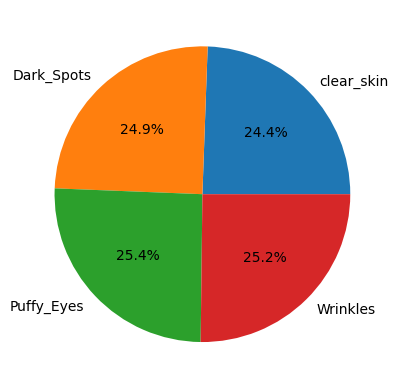

In [231]:
plt.pie(x_values , labels = y_values , autopct='%1.1f%%')

In [5]:
def model_training(base,num_epochs,learning_rate):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(base.parameters() , lr = learning_rate)
        
        train_loss , val_loss , train_acc , val_acc = [] , [] , [] , []
        for i in range(num_epochs):
            base.train()
            running_loss , running_corrects  = 0.0 , 0
            for X , Y in train_loader:

                logit = base(X)
                loss = criterion(logit , Y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * X.size(0)
                _,preds = torch.max(logit , 1)
                running_corrects += torch.sum(preds == Y)

            epoch_train_loss = running_loss / len(train_loader.dataset)
            epoch_train_acc = running_corrects.double() /len(train_loader.dataset)

            train_loss.append(epoch_train_loss)
            train_acc.append(epoch_train_acc)


            base.eval()
            val_running_loss , val_running_corrects = 0.0 , 0
            with torch.no_grad():
                for X_val , Y_val in val_loader:
                    pred = base(X_val)
                    loss_val = criterion(pred , Y_val)

                    val_running_loss += loss_val.item() * X_val.size(0)
                    _,val_pred = torch.max(pred , 1)
                    val_running_corrects += torch.sum(val_pred == Y_val)
                
                epoch_val_loss = val_running_loss / len(val_loader.dataset)
                epoch_val_acc = val_running_corrects.double() / len(val_loader.dataset)

            val_loss.append(epoch_val_loss)
            val_acc.append(epoch_val_acc)

            print(f"Epoch {i+1}/{num_epochs} | "
                f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
                f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}") 
            
        return train_loss , train_acc , val_loss , val_acc

In [6]:
def plot(train_loss , train_acc , val_loss , val_acc , num_epochs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,12))
    epochs = range(1 , num_epochs + 1)
    plt.subplot(1,2,1)
    plt.plot(epochs , train_acc , label = 'Train_Accuracy' , color = 'r')
    plt.plot(epochs , val_acc , label = 'Validation_Accuracy' , color = 'b' )
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(2,2,2)
    plt.plot(epochs , train_loss , label = 'Train_Loss' , color = 'r')
    plt.plot(epochs , val_loss , label = 'Val_Loss' , color = 'b')
    plt.title('Loss')
    plt.legend()


## EfficientNet_B0

Epoch 1/15 | Train Loss: 1.2922, Train Acc: 0.4371 | Val Loss: 1.1345, Val Acc: 0.6329
Epoch 2/15 | Train Loss: 1.0386, Train Acc: 0.6730 | Val Loss: 0.9186, Val Acc: 0.7848
Epoch 3/15 | Train Loss: 0.9067, Train Acc: 0.7516 | Val Loss: 0.8173, Val Acc: 0.7595
Epoch 4/15 | Train Loss: 0.7685, Train Acc: 0.8113 | Val Loss: 0.7514, Val Acc: 0.7342
Epoch 5/15 | Train Loss: 0.6901, Train Acc: 0.8208 | Val Loss: 0.7058, Val Acc: 0.7468
Epoch 6/15 | Train Loss: 0.6286, Train Acc: 0.8302 | Val Loss: 0.6666, Val Acc: 0.7595
Epoch 7/15 | Train Loss: 0.5795, Train Acc: 0.8396 | Val Loss: 0.6245, Val Acc: 0.7848
Epoch 8/15 | Train Loss: 0.5458, Train Acc: 0.8585 | Val Loss: 0.6009, Val Acc: 0.8101
Epoch 9/15 | Train Loss: 0.4919, Train Acc: 0.8868 | Val Loss: 0.5862, Val Acc: 0.8101
Epoch 10/15 | Train Loss: 0.4685, Train Acc: 0.8899 | Val Loss: 0.5702, Val Acc: 0.7975
Epoch 11/15 | Train Loss: 0.4363, Train Acc: 0.8962 | Val Loss: 0.5506, Val Acc: 0.8101
Epoch 12/15 | Train Loss: 0.4281, Train A

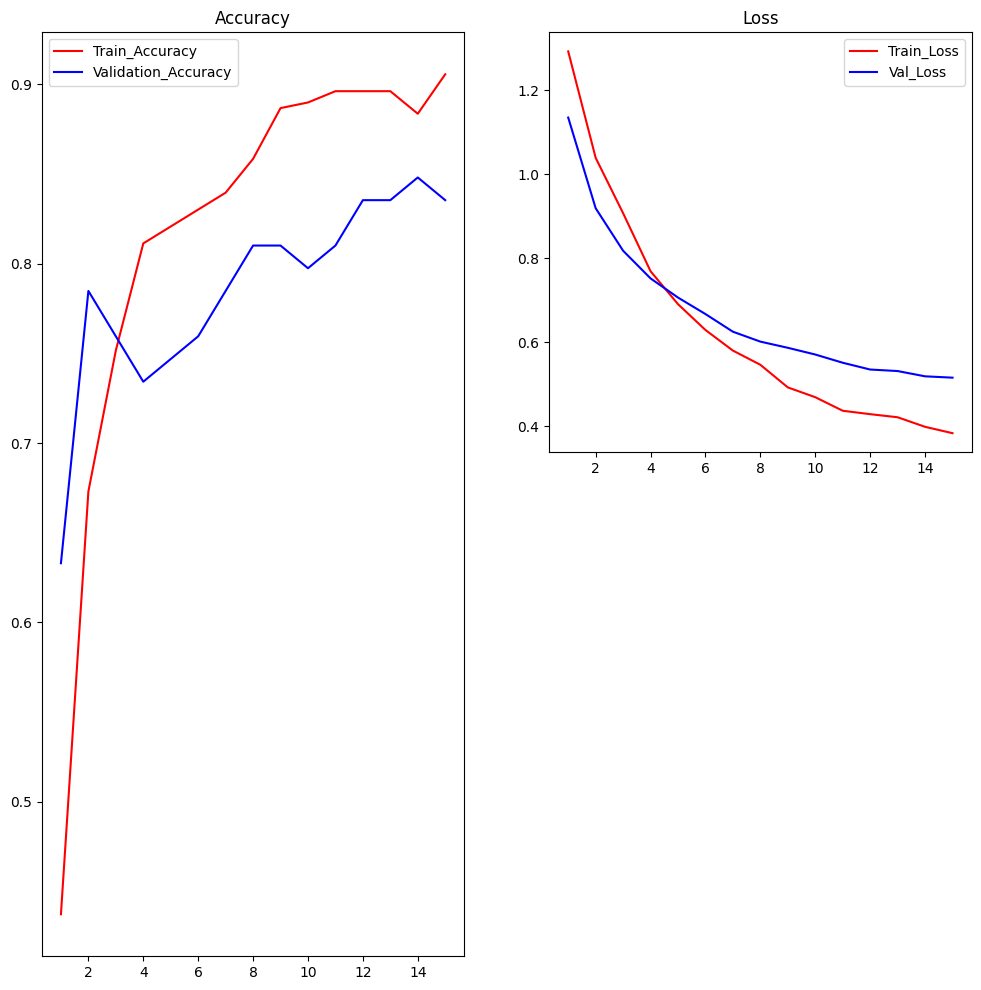

In [263]:
epochs = 15
learning_rate = 0.001
w = models.EfficientNet_B0_Weights.IMAGENET1K_V1
Model_efficient_Net = models.efficientnet_b0(weights = w)

for p in Model_efficient_Net.parameters():
    p.requires_grad = False
    
in_features = Model_efficient_Net.classifier[1].in_features

Model_efficient_Net.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features = 1280 , out_features = 4)
)

x,y,z,a = model_training(Model_efficient_Net , epochs, learning_rate)

plot(x,y,z,a , epochs)

torch.save(Model_efficient_Net, 'Efficient_Net_B0.pth')

## MobileNet_v2

Epoch 1/15 | Train Loss: 1.2144, Train Acc: 0.4811 | Val Loss: 1.1196, Val Acc: 0.5949
Epoch 2/15 | Train Loss: 0.9035, Train Acc: 0.6981 | Val Loss: 0.7742, Val Acc: 0.7342
Epoch 3/15 | Train Loss: 0.7216, Train Acc: 0.7579 | Val Loss: 0.6562, Val Acc: 0.8228
Epoch 4/15 | Train Loss: 0.6324, Train Acc: 0.8145 | Val Loss: 0.6030, Val Acc: 0.8228
Epoch 5/15 | Train Loss: 0.5707, Train Acc: 0.8019 | Val Loss: 0.5467, Val Acc: 0.8481
Epoch 6/15 | Train Loss: 0.4883, Train Acc: 0.8585 | Val Loss: 0.5385, Val Acc: 0.8354
Epoch 7/15 | Train Loss: 0.4544, Train Acc: 0.8616 | Val Loss: 0.5030, Val Acc: 0.8734
Epoch 8/15 | Train Loss: 0.4545, Train Acc: 0.8774 | Val Loss: 0.4871, Val Acc: 0.8481
Epoch 9/15 | Train Loss: 0.3920, Train Acc: 0.8962 | Val Loss: 0.5022, Val Acc: 0.8481
Epoch 10/15 | Train Loss: 0.3739, Train Acc: 0.8805 | Val Loss: 0.4725, Val Acc: 0.8354
Epoch 11/15 | Train Loss: 0.3591, Train Acc: 0.8962 | Val Loss: 0.4677, Val Acc: 0.8734
Epoch 12/15 | Train Loss: 0.3476, Train A

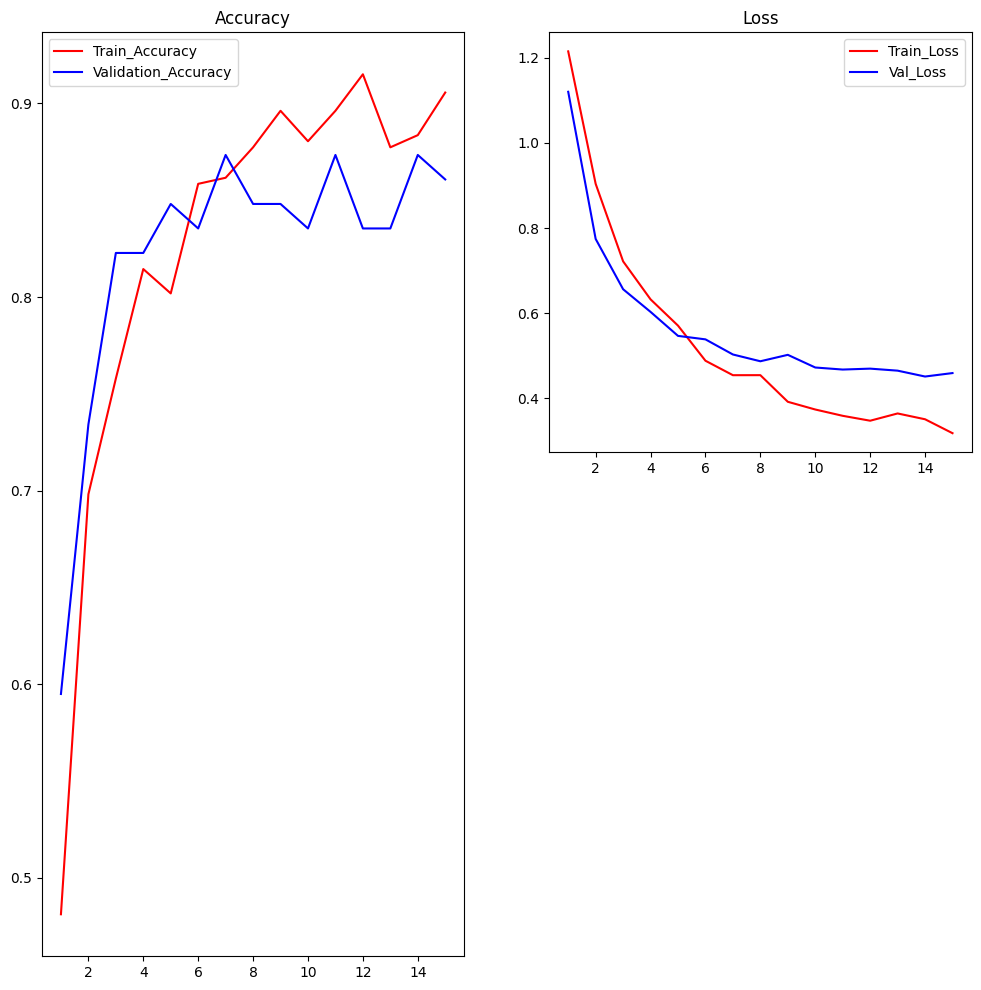

In [264]:
epochs = 15
learning_rate = 0.001
w = models.MobileNet_V2_Weights.IMAGENET1K_V1
Model_Mobile_Net = models.mobilenet_v2(weights = w)

for p in Model_Mobile_Net.features.parameters():
    p.requires_grad = False

input = Model_Mobile_Net.classifier[1].in_features

Model_Mobile_Net.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(input , 4)
)

x,y,z,a = model_training(Model_Mobile_Net , epochs , learning_rate)

plot(x,y,z,a,epochs)

torch.save(Model_Mobile_Net , 'Model_Mobile_Net.pth')

## DENSE121

Epoch 1/20 | Train Loss: 1.3596, Train Acc: 0.3553 | Val Loss: 1.1977, Val Acc: 0.4810
Epoch 2/20 | Train Loss: 1.1140, Train Acc: 0.5629 | Val Loss: 0.9724, Val Acc: 0.7089
Epoch 3/20 | Train Loss: 0.9488, Train Acc: 0.7170 | Val Loss: 0.8405, Val Acc: 0.7722
Epoch 4/20 | Train Loss: 0.8078, Train Acc: 0.7736 | Val Loss: 0.7707, Val Acc: 0.7848
Epoch 5/20 | Train Loss: 0.7169, Train Acc: 0.7956 | Val Loss: 0.7008, Val Acc: 0.8101
Epoch 6/20 | Train Loss: 0.6516, Train Acc: 0.8113 | Val Loss: 0.6652, Val Acc: 0.8101
Epoch 7/20 | Train Loss: 0.6114, Train Acc: 0.8145 | Val Loss: 0.6302, Val Acc: 0.8101
Epoch 8/20 | Train Loss: 0.5910, Train Acc: 0.8208 | Val Loss: 0.6044, Val Acc: 0.8228
Epoch 9/20 | Train Loss: 0.5469, Train Acc: 0.8396 | Val Loss: 0.5878, Val Acc: 0.8101
Epoch 10/20 | Train Loss: 0.4963, Train Acc: 0.8774 | Val Loss: 0.5669, Val Acc: 0.8481
Epoch 11/20 | Train Loss: 0.4566, Train Acc: 0.8774 | Val Loss: 0.5576, Val Acc: 0.8481
Epoch 12/20 | Train Loss: 0.4590, Train A

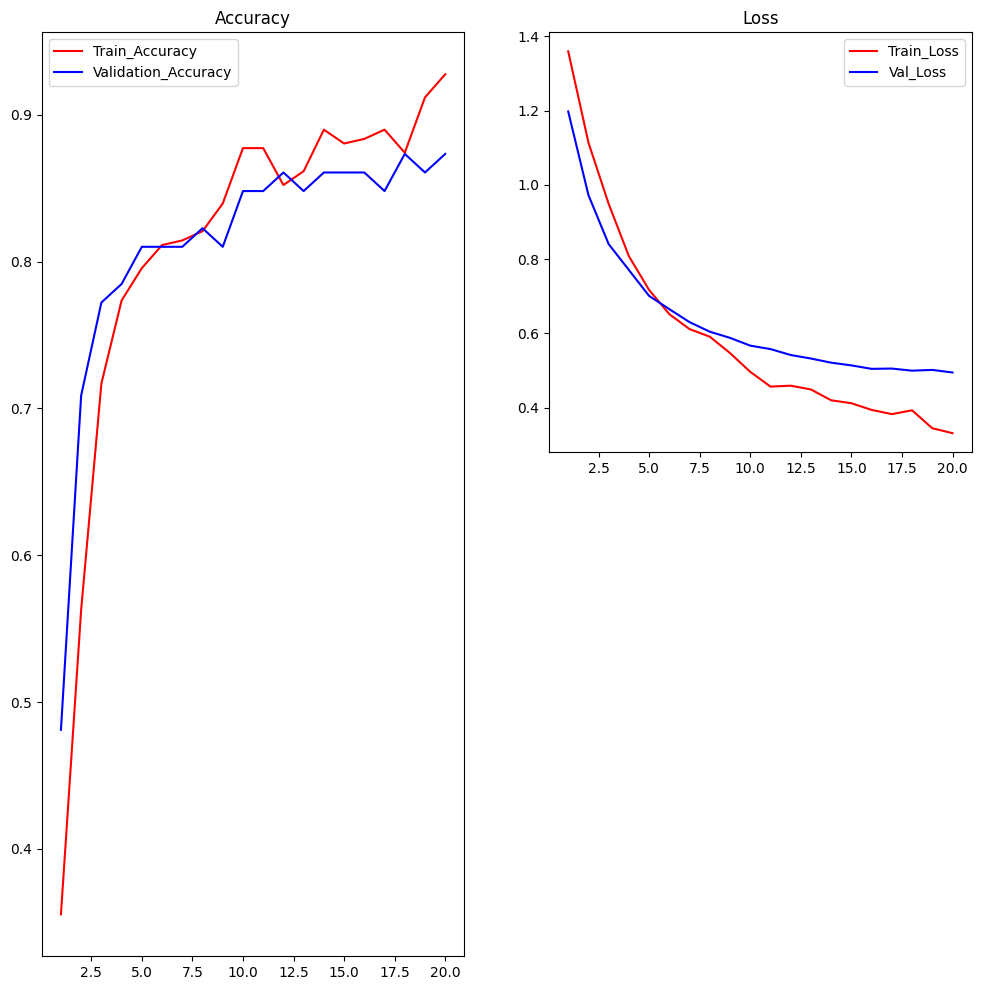

In [265]:
epochs = 20
learning_rate = 0.001

w = models.DenseNet121_Weights.IMAGENET1K_V1
Model_Dense121_Net = models.densenet121(weights = w)

for p in Model_Dense121_Net.parameters():
    p.requires_grad = False

input = Model_Dense121_Net.classifier.in_features
Model_Dense121_Net.classifier = nn.Linear(input , 4)

x,y,z,a = model_training(Model_Dense121_Net , epochs , learning_rate)

plot(x,y,z,a,epochs)

torch.save(Model_Dense121_Net , 'Dense121_Net.pth')


## Model_Comparision

In [8]:
model_list = {
    'Mobile_Net_v2' : 'Model_Mobile_Net.pth',
    'Dense121_Net'  : 'Dense121_Net.pth',
    'Efficient_Net_B0' : 'Efficient_Net_B0.pth'
}

In [9]:
transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485 , 0.456 , 0.406] , std = [0.229 , 0.224 , 0.225])
    ])

In [10]:
from PIL import Image
import os

image_list = []

for image in os.listdir('validation_images'):
    path = os.path.join('validation_images',image)
    img = Image.open(path).convert('RGB')
    input_tensor = transform(img)
    image_list.append(input_tensor)
test_tensor = torch.stack(image_list)

In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [12]:
def model_eval(model_name, path, input_tensors):
    model = torch.load(path, map_location='cpu')
    model.eval()
    class_names = ['clear_face', 'Darkspots', 'Puffy_Eyes', 'Wrinkles']

    print(f'\nModel: {model_name}')
    with torch.no_grad():
        for i in range(len(input_tensors)):
            img = input_tensors[i].unsqueeze(0)

            pred = model(img)
            probs = F.softmax(pred, dim=1) 
            pred_class = torch.argmax(probs, dim=1).item()
            confidence = probs[0][pred_class].item()  
            
            img_np = input_tensors[i].permute(1,2,0).numpy()
            img_np = img_np * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
            img_np = np.clip(img_np, 0, 1)

            plt.figure(figsize=(6,6))
            plt.imshow(img_np)
            plt.title(f'{class_names[pred_class]} | Confidence: {confidence:.2f}')
            plt.axis('off')
            plt.show()


            print(f'Prediction : {class_names[pred_class]} | Confidence : {confidence}')


Model: Mobile_Net_v2


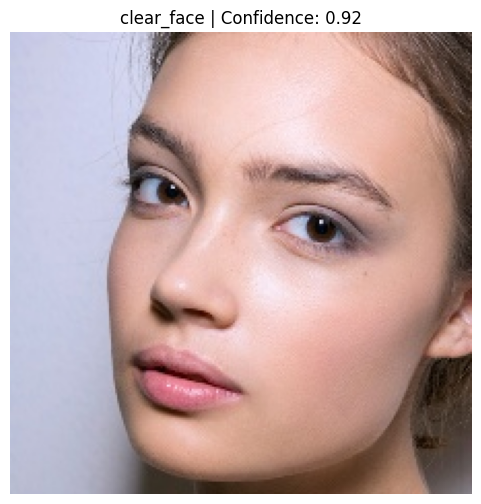

Prediction : clear_face | Confidence : 0.9229361414909363


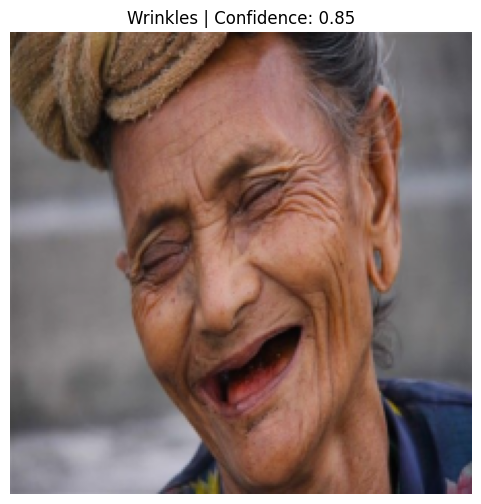

Prediction : Wrinkles | Confidence : 0.8478472828865051


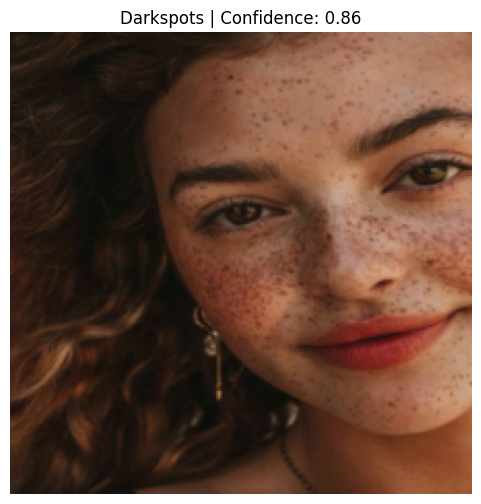

Prediction : Darkspots | Confidence : 0.8596285581588745


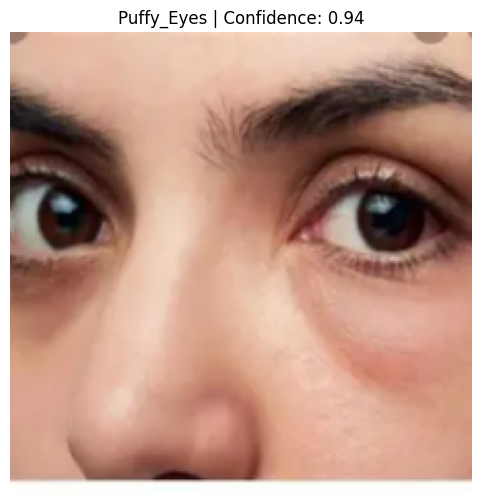

Prediction : Puffy_Eyes | Confidence : 0.9386011362075806

Model: Dense121_Net


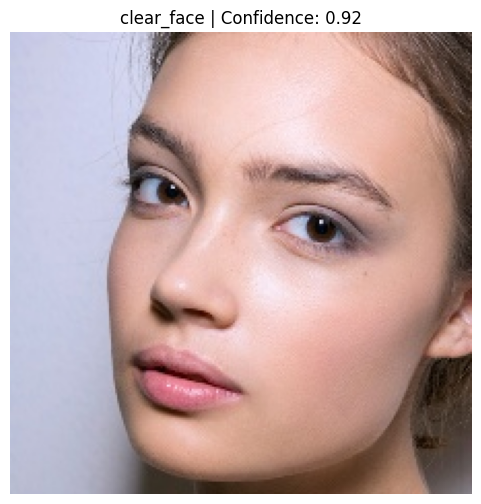

Prediction : clear_face | Confidence : 0.9227340221405029


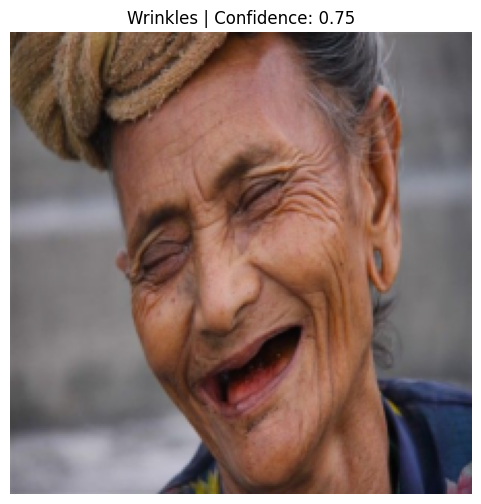

Prediction : Wrinkles | Confidence : 0.7546477913856506


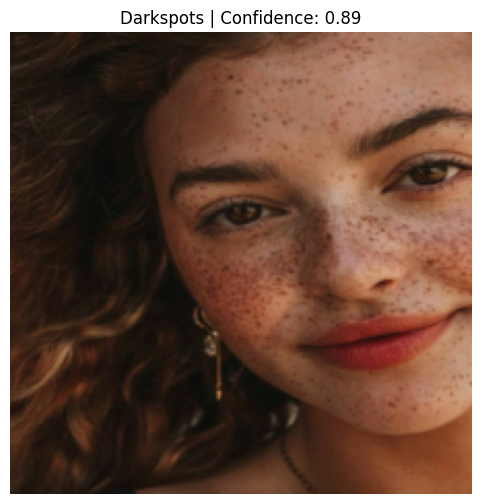

Prediction : Darkspots | Confidence : 0.8944300413131714


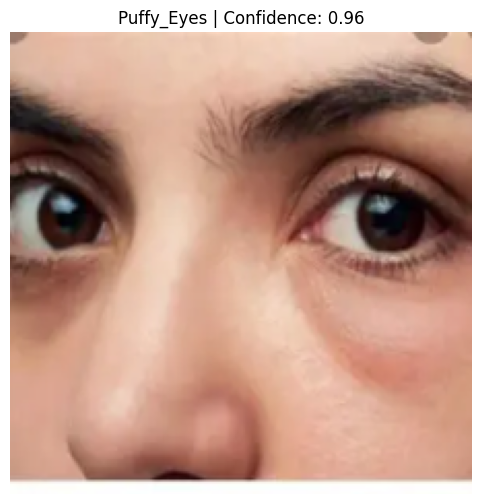

Prediction : Puffy_Eyes | Confidence : 0.9582971930503845

Model: Efficient_Net_B0


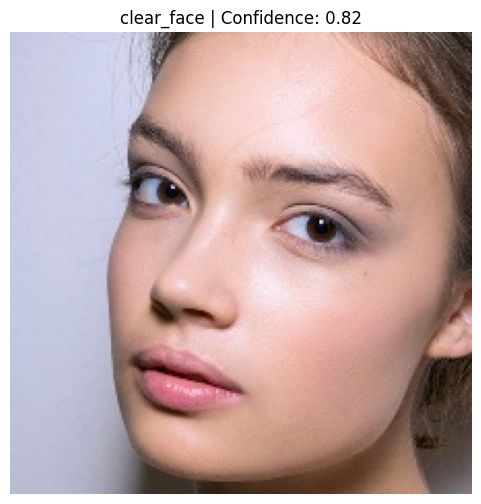

Prediction : clear_face | Confidence : 0.822524905204773


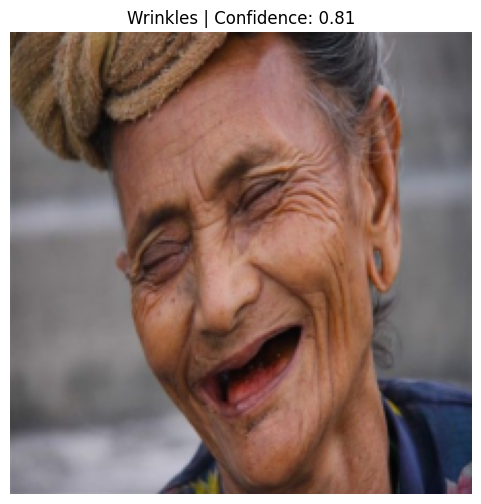

Prediction : Wrinkles | Confidence : 0.8057528734207153


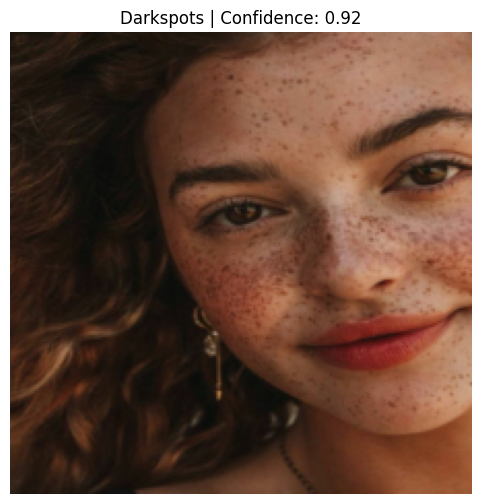

Prediction : Darkspots | Confidence : 0.9170687794685364


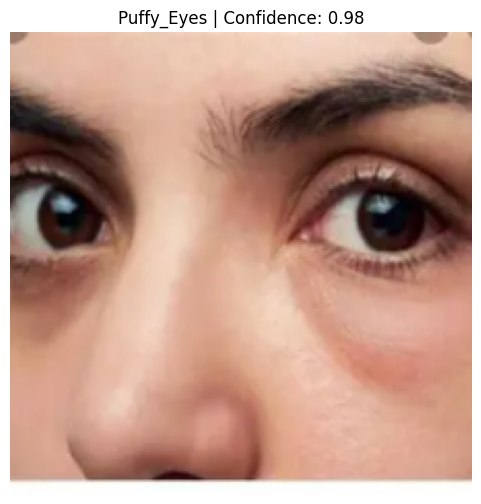

Prediction : Puffy_Eyes | Confidence : 0.9785265922546387


In [13]:
for model_name , path in model_list.items():
    model_eval(model_name , path , test_tensor)

## Models Accuracy

In [277]:
import pandas as pd

In [242]:
val_loader = DataLoader(val_set , batch_size = len(val_set) , shuffle = False)
def model_accuracy(model_list):
    model_acc = []
    for n , p in model_list.items():
        model = torch.load(p)
        count = 0
        for images , labels in val_loader:
            pred = torch.argmax(nn.functional.softmax(model(images),dim = 1),dim = 1)
            ac = accuracy_score(pred , labels)
            model_acc.append(ac)
    return model_acc

In [243]:
model_acc = model_accuracy(model_list)

In [278]:
lis = []
for ans in zip(model_list.keys(),model_acc):
    lis.append(ans)
ar = np.array(lis)


In [280]:
df = pd.DataFrame({'Model':ar[:,0] ,'Accuracy':ar[:,1]})
df

,Model,Accuracy
0,Mobile_Net_v2,0.8607594936708861
1,Dense121_Net,0.8734177215189873
2,Efficient_Net_B0,0.8354430379746836


In [245]:
model_list

{'Mobile_Net_v2': 'Model_Mobile_Net.pth',
 'Dense121_Net': 'Dense121_Net.pth',
 'Efficient_Net_B0': 'Efficient_Net_B0.pth'}

## OPTIONAL (ENSEMBLE OF MODELS)

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score

In [203]:
models_array = []
def ensemble(model_list):
    for i in model_list.values():
        models_array.append(torch.load(i))
    
    ensembles = np.zeros((1,3))
    labels = np.zeros((1,))
    
    for image , label in val_loader:
        labels = np.concatenate((labels,label))
        pred_array = np.zeros((len(image) , 1))
        
        for m in models_array:
            pred = torch.argmax(torch.nn.functional.softmax(m(image) , dim = 1),dim =1)
            pred_array = np.concatenate((pred_array , pred.view(len(image),-1)),axis = 1)
        
        ensembles = np.concatenate((ensembles,pred_array[:,1:]),axis = 0)
    return ensembles , labels

In [204]:
ensembles , labels = ensemble(model_list)

In [205]:
predictions = ensembles[1:,:].astype(int)
Y = labels[1:]

In [206]:
labels = []
for i in predictions:
    labels.append(np.bincount(i).argmax())

In [207]:
labels = np.array(labels)

In [208]:
from sklearn.metrics import accuracy_score

In [209]:
accuracy_score(labels , Y)

0.8607594936708861